# Problem Statement

CIFAR-10 is a dataset of 32x32 images in 10 categories, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It is often used to evaluate machine learning algorithms. You can download this dataset from https://www.cs.toronto.edu/~kriz/cifar.html. You should combine the test and train sets (all the images) and separate them by category.

For each category, compute the mean image and the first 20 principal components. Plot the error resulting from representing the images of each category using the first 20 principal components against the category as a bar graph (refer to the Procedures section for clarifications).
Compute the distances between mean images for each pair of classes. Use principal coordinate analysis (refer to the Procedures section for clarifications) to make a 2D map of the means of each categories. (Follow procedure 7.2 on page 120 of the book)
Here is another measure of the similarity of two classes. For class A and class B, define E(A → B) to be the average error obtained by representing all the images of class A using the mean of class A and the first 20 principal components of class B (Refer to Procedures section for explicit definition). This should tell you something about the similarity of the classes. Now define the distance metric between classes to be 
(1/2)(E(A → B) + E(B → A)). Use principal coordinate analysis to make a 2D map of the classes. Compare this map to the map in the previous exercise – are they different? why?

Procedures
Outline
For all error calculations, it will be helpful to flatten your images. After compiling the data from the dataset, you will likely have it in a 4-D array with shape (60000, 32,32,3). Flattening the images should give you a 2-D array with shape (60000, 3072). This will make the following computations easier to understand.

Part A
For each class, find the mean image, and compute the first 20 principal components.
Now use the mean as well as the principle components to compute a low-dimensional reconstruction of each image in the class. Hint: Libary functions will come in handy here. Refer to section 7.1.2 and 7.1.3 for theory.
Now for each image, compute the squared difference between the original and reconstructed version, and sum this over all pixels over all channels. If you have flattened your images, this is simply the squared euclidean distance between the image vectors. Take the average of the value you computed above over all images in the class.
Plot the above value in the bar graph against its category/class label. You will submit this plot.
Part B
Compute a 10 x 10 distance matrix D such that D[i,j] is the Euclidean distance between the mean images of class i and class j. Square the elements of this matrix and write it out to a CSV file named partb_distances.csv. You will submit this file.
Note: The order of the class labels is very important here, as this file will be autograded. Refer to this for the index-label mapping, and ensure yours matches.
Now you must perform multi-dimensional scaling with the squared distance matrix you have. Refer to the MDS section for details on how to do that.
Once you have computed the scaled points in 2-D space, plot the first component along the x-axis and component 2 along the y-axis of a scatter plot. You will submit this plot.
Part C
Just like in Part B, you will first compute a 10 x 10 distance matrix. However, here, D[i,j] will contain E(i → j). Let's define E(A → B).
E(A → B) = (E(A| B) + E(B|A))/2
To compute E(A|B), use the mean image of class A and the first 20 principal components of class B to reconstruct the images of class A
Once you have the reconstructed images, use the procedure described in steps 3 and 4 of Part A to compute the mean of the sum of pixel-wise squared difference between the reconstructed and original images.
Similarly compute E(B|A).
Note: E(A|A) != 0, as a sanity check.
Once you have computed D, write it out to a CSV file named partc_distances.csv. You will submit this file. Again, make sure the index-label ordering is correct in your matrix. 
Note: There is no need to square the values in D as they are already averaged square distances.
Perform MDS with this distance matrix, and once you have the scaled points in 2-D, plot the first component along the x-axis and component 2 along the y-axis of a scatter plot. You will submit this plot.

Principal Coordinate Analysis (MDS)
For the following procedure, the set of points whose mutual distances you will start out with are the mean images of each class. Note: Be careful not to accidentally square your already squared distances matrices when implementing the second bullet point below.

Assume we have a matrix D(2) consisting of squared differences between each pair of N points, and we wish to compute a set of points in s dimensions, such that the distances between these points are as similar as possible to the distances in D(2).

First form the centering matrix A as described in section 7.1.2 on page 118. A = I - 1⁄N11T
Now form W = -½AD(2)AT
Next, form U and Λ such that WU = UΛ. These are respectively the eigenvectors and eigenvalues of W. Ensure that the entries of Λ are sorted in decreasing order. Notice that you need only the top s eigenvalues and their eigenvectors, and many packages can extract these quickly, instead of constructing all of them.
Choose s, the number of dimensions you wish to represent. Form Λs, the top left s x s block of Λ.
Form Λs½, whose entries are the positive square roots of Λs. Construct Us, the matrix consisting of the first s columns of U.
Finally, compute Y = UsΛs½ = [v1, . . . , vN] . This is the set of points you must plot.

In [ ]:
import pandas as pd
import numpy as np
import scipy as sc
from sklearn import decomposition
from scipy.misc import imresize as im
from matplotlib import cm as cm
from sklearn.manifold import MDS
from PIL import Image
import pickle
import os
from matplotlib import pyplot as plt

def unpickle_meta(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return np.array([x.decode('UTF-8') for x in np.array(dict[b'label_names'])])

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    feature_data = np.array(dict[b'data']).reshape(10000,3072)  
    class_data = np.array(dict[b'labels'])
    return feature_data, class_data


def calculate_original_pca_difference(original_data, pca_data):
    pca_error_per_class = np.mean(np.sum((np.power((np.subtract(original_data, pca_data)), 2)), axis=1), axis=0)
    return pca_error_per_class

def MDS_custom(data, s):
    n = data.shape[1]
    A = np.identity(n) - (1/n) * np.ones([n,n])
    W = (-.5) * np.dot(np.dot(A, data), A.transpose())
    eigval, eigvec = sc.linalg.eigh(W)
    eigval = np.flip(eigval[-s:], 0)
    eigvec = np.flip(eigvec[:,-s:],1)
    d = len(eigval)
    diag = np.zeros([d,d])
    idx, = np.where(eigval > 0)
    for i, eig in enumerate(eigval[idx]):
        diag[i,i] = np.sqrt(eig)
    return np.dot(eigvec, diag)

classes = unpickle_meta('batches.meta')
X_batch1, y_batch1 = unpickle('data_batch_1')
X_batch2, y_batch2 = unpickle('data_batch_2')
X_batch3, y_batch3 = unpickle('data_batch_3')
X_batch4, y_batch4 = unpickle('data_batch_4')
X_batch5, y_batch5 = unpickle('data_batch_5')
X_test, y_test = unpickle('test_batch')
X_train = np.concatenate((X_batch1, X_batch2, X_batch3, X_batch4, X_batch5, X_test), axis=0)
y_train = np.concatenate((y_batch1, y_batch2, y_batch3, y_batch4, y_batch5, y_test), axis=0)

data_df = pd.DataFrame(X_train, index=y_train)
pca = decomposition.PCA(n_components=20)
eigen_vectors = []
pca_error_all_classes = []
centred_features_all_classes = []
mean_features_all_classes = []
offcentred_images = []

for x in range(10):
    class_specific_features = data_df[data_df.index==x]
    offcentred_images.append(class_specific_features)    
    mean_features_per_class = np.mean(class_specific_features)  
    mean_features_all_classes.append(mean_features_per_class)    
    centred_features_per_class = class_specific_features - mean_features_per_class
    centred_features_all_classes.append(centred_features_per_class)    
    pca_features_per_class = pca.fit_transform(centred_features_per_class) 
    inversed_pca_features_per_class = pca.inverse_transform(pca_features_per_class)
    eigen_vectors.append(np.array(pca.components_).transpose())    
    pca_error_per_class = calculate_original_pca_difference(centred_features_per_class, inversed_pca_features_per_class)
    pca_error_all_classes.append(pca_error_per_class)
import json
with open('hw4_label_ordering.json') as f:
    class_list = json.load(f)
    

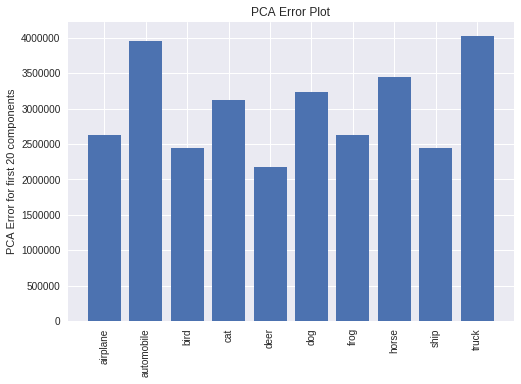

In [4]:
#part-A

index = np.arange(len(classes))
plt.bar(index, pca_error_all_classes)
plt.ylabel("PCA Error for first 20 components")
plt.axis('tight')
plt.xticks(index, classes, rotation = 'vertical') 
plt.margins(0.2)
plt.title("PCA Error Plot")
#plt.savefig('pca_error_partA.png', bbox_inches='tight')
#plt.close()
plt.show()

In [11]:
type(class_list)

dict

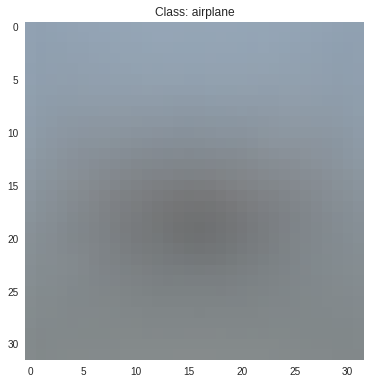

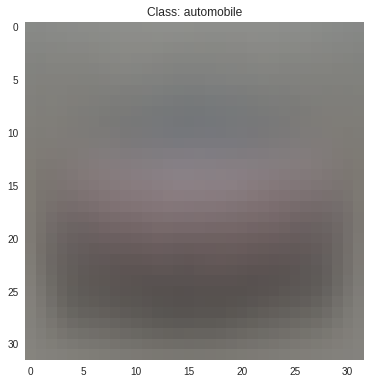

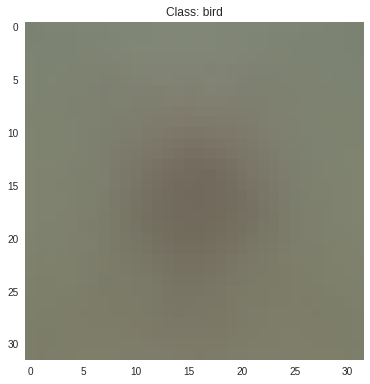

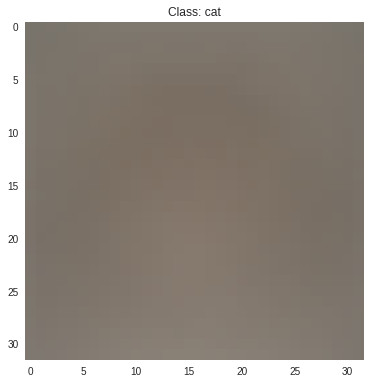

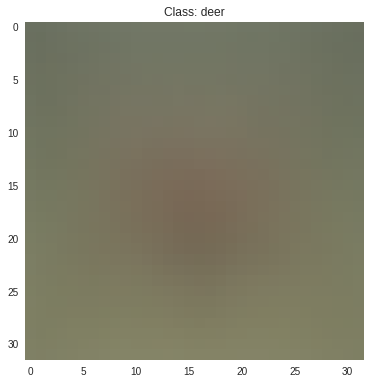

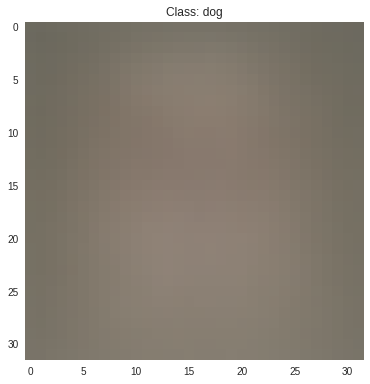

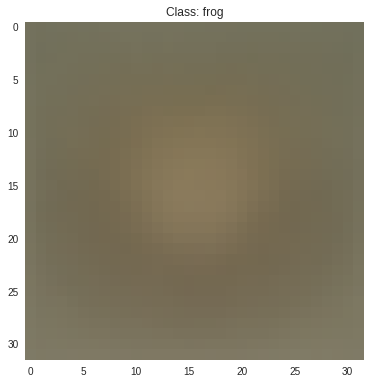

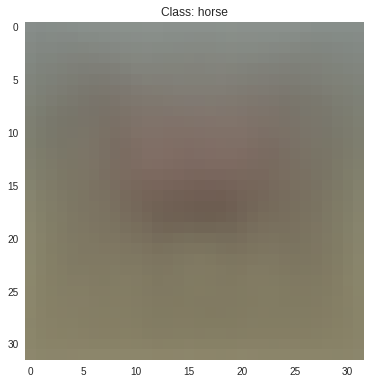

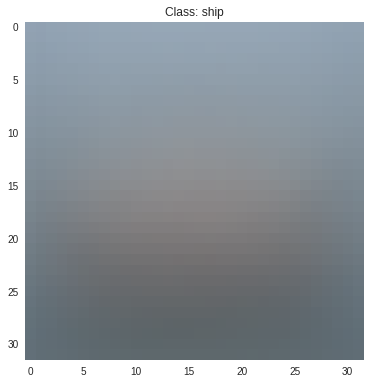

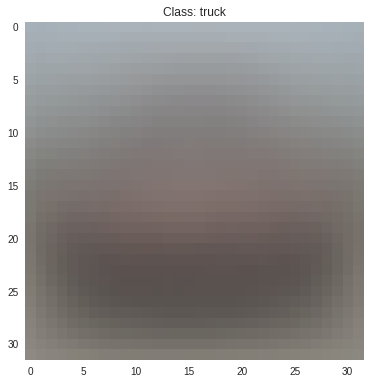

In [14]:
def disp_image(x):
    image1 = np.array(mean_features_all_classes[x])
    R = image1[:1024].reshape(32,32)/255.0
    G = image1[1024:2048].reshape(32,32)/255.0
    B = image1[2048:3072].reshape(32,32)/255.0
    img = np.dstack((R,G,B))
    fig = plt.figure()
    ax =  fig.add_subplot(111)
    ax.grid(False)
    ax.imshow(img)
    title = "Class: " + str(class_list[str(x)]) 
    plt.title(title)
    plt.tight_layout()
    
for i in range(10):
  disp_image(i)   

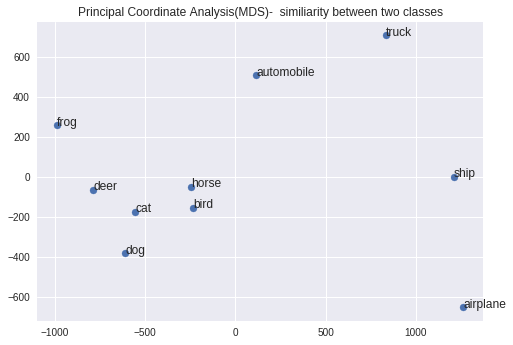

In [23]:
#part-B

euclidian_distance = []
for i in range(len(mean_features_all_classes)):
    for j in range((len(mean_features_all_classes))):
        distance = np.linalg.norm(mean_features_all_classes[i] - mean_features_all_classes[j])
        euclidian_distance.append(distance)
euclidian_distance = np.power(np.array(euclidian_distance).reshape(10,10),2)
#np.savetxt("partb_distances.csv", euclidian_distance, fmt='%1.4f', delimiter=',')

fit_mds = MDS_custom(euclidian_distance, 2)
plt.scatter(fit_mds[:, 0], fit_mds[:, 1])
plt.title('Principal Coordinate Analysis(MDS)-  similiarity between two classes')
for index, class_name in class_list.items():
    plt.annotate(class_name, (
    fit_mds[int(index)][0], fit_mds[int(index)][1]))  
plt.show()


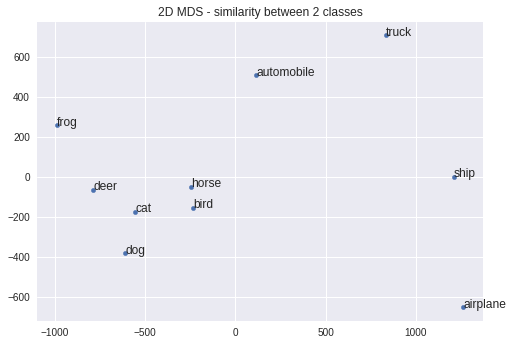

In [25]:
#part-c

pca_error_list = []

for i in range(0, 10):
    for j in range(0, 10):
      per_pixel_rotation = np.dot(np.array(eigen_vectors[j]).transpose(), np.array(centred_features_all_classes[i]).transpose())
      rotated_matrix = np.dot(np.array(eigen_vectors[j]), per_pixel_rotation).transpose()  
      reconstructed_image = np.array(rotated_matrix) + np.array(mean_features_all_classes[i])  
      diff = calculate_original_pca_difference(offcentred_images[i], reconstructed_image)  
      pca_error_list.append(diff)

pca_error_matrix = (np.array(pca_error_list).reshape(10, 10)) 
similarity_matrix = []

for i in range(0, 10):
    for j in range(0, 10):
       similarity_matrix.append((1 / 2) * (pca_error_matrix[i, j] + pca_error_matrix[j, i]))

similarity_matrix = np.array(similarity_matrix).reshape(10, 10)
#np.savetxt("partc_distances.csv", similarity_matrix, fmt='%1.4f', delimiter=',')

fit_mds = MDS_custom(euclidian_distance, 2)

plt.scatter(fit_mds[:, 0], fit_mds[:, 1], s=20)  # Plotting the 2 dimensions
plt.title('2D MDS - similarity between 2 classes')
for index, class_name in class_list.items():
    plt.annotate(class_name, (fit_mds[int(index)][0], fit_mds[int(index)][1])) 
plt.axis('tight')
plt.show()

